# Predicting California House Prices — Decision Tree vs Random Forest

**Summary:** Built and compared Decision Tree and Random Forest regressors on the California Housing dataset (features: MedInc, HouseAge, Population, AveOccup, Latitude, Longitude). Random Forest produced a lower MAE (0.3262).

**Dataset:** California Housing dataset (scikit-learn) — `fetch_california_housing()`.

**Objective:**  
- Compare Decision Tree and Random Forest performance.  
- Train final Random Forest on full data and save the model.  
- Share reproducible notebook + results on GitHub and LinkedIn.

**Notebook sections:**  
1. Imports & reproducibility  
2. Data loading & EDA  
3. Preprocessing & scaling  
4. Model training & validation (DT vs RF)  
5. Final training on full dataset & model saving  
6. Visualizations (feature importance, predicted vs actual)  
7. Conclusion & next steps


In [34]:
# Reproducibility + imports
import os
import random
import numpy as np
import pandas as pd
import sklearn
import joblib

# set seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
# scikit-learn estimators accept random_state=SEED when created

# common imports you probably used
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

print("Python version:", os.sys.version.splitlines()[0])
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1
joblib: 1.5.2


## Preparing Data

In [35]:
housing = fetch_california_housing()
dataset = pd.DataFrame(data = housing.data, columns= housing.feature_names)

print("✅ Data loaded successfully!")
print("Shape of dataset:", dataset.shape)
dataset.head()

✅ Data loaded successfully!
Shape of dataset: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Dataset Overview

The dataset contains information about California districts such as median income, house age, population, and geographical coordinates.  
The target variable (`Price`) represents the median house value (in hundreds of thousands of dollars).

Let's explore it to understand the feature distributions and relationships.


# EDA (Exploratory Data Analysis) & Data Overview

In [36]:
dataset['Price'] = housing.target
dataset.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


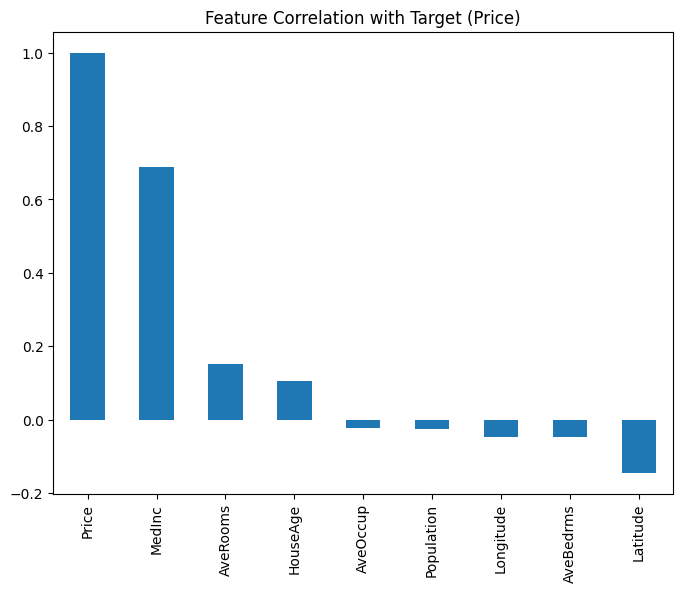

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.title("Feature Correlation with Target (Price)")
dataset.corr()['Price'].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [38]:

dataset.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Price,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


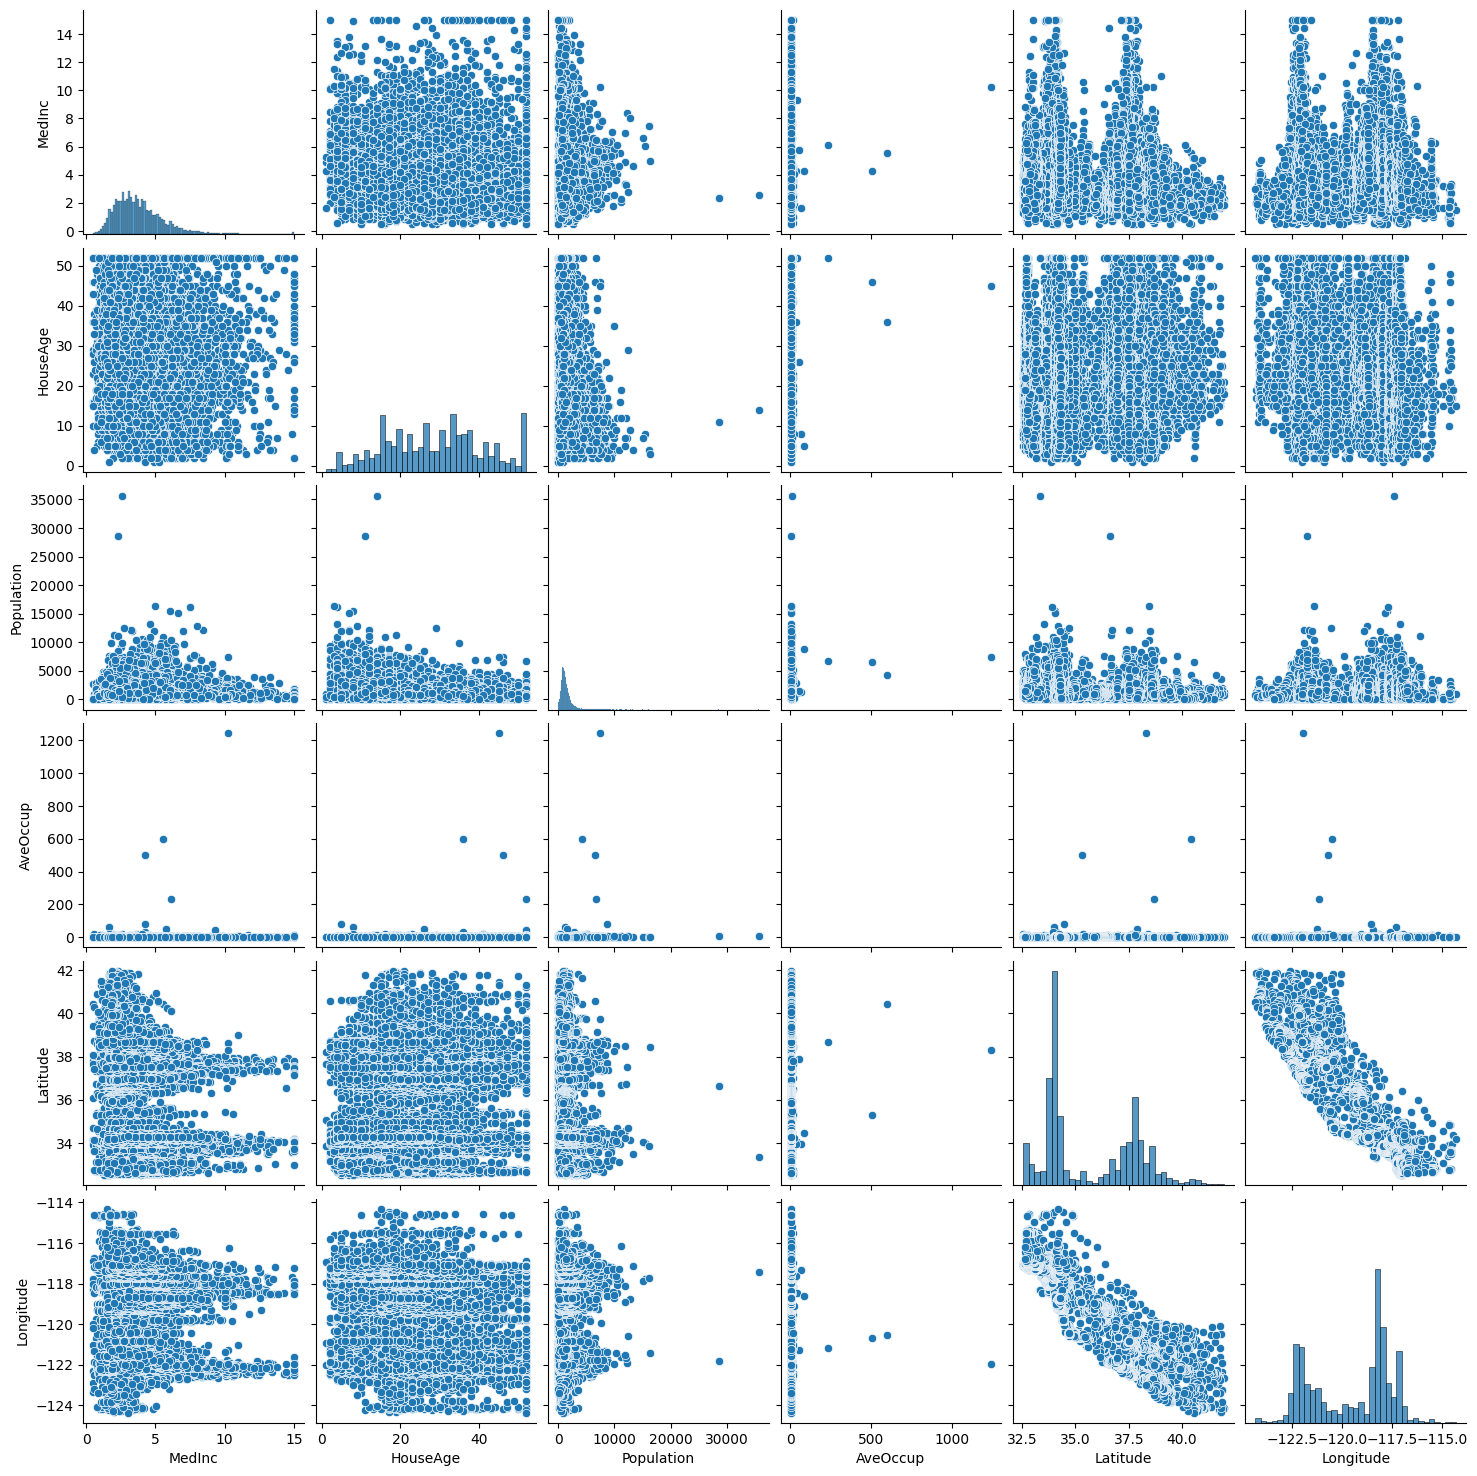

In [39]:
sns.pairplot(X)

### Key Observations
- **Median Income** has the strongest positive correlation with house price.
- **Latitude** and **Longitude** show geographical influence.
- Other features have weaker correlations individually, but may still contribute in combinations.

Next, we’ll split the data, train the Decision Tree and Random Forest models, and compare their Mean Absolute Errors (MAE).


# Model Training and Evaluation(Decision Tree Regressor and Random Forest)

In [40]:
features = ['MedInc', 'HouseAge', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X = dataset[features]
y = dataset['Price']
X.head()

,MedInc,HouseAge,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,565.0,2.181467,37.85,-122.25


In [41]:
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state=1)

# Decision Tree Regressor

In [42]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state =1)
dt_model.fit(train_X, train_y)

DecisionTreeRegressor(random_state=1)

In [43]:
val_preds = dt_model.predict(val_X)
val_mae = mean_absolute_error(val_y, val_preds)
print("Validation MAE for Decision Tree Model: {}".format(val_mae))

Validation MAE for Decision Tree Model: 0.4485696162790699


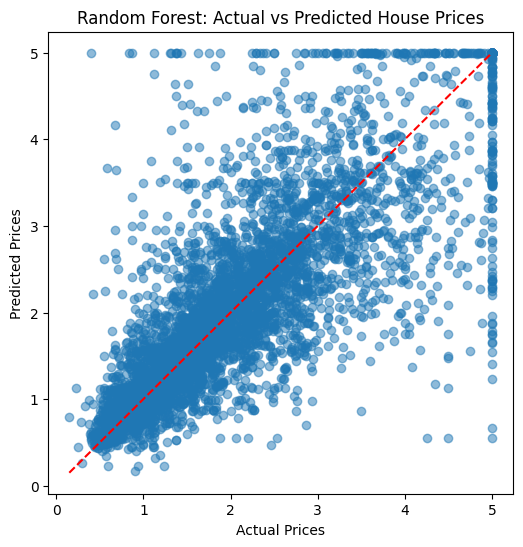

In [44]:
# Visual comparison between predicted vs actual prices
plt.figure(figsize=(6,6))
plt.scatter(val_y, val_preds, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest: Actual vs Predicted House Prices")
plt.plot([val_y.min(), val_y.max()], [val_y.min(), val_y.max()], 'r--')
plt.show()


# Random Forest Model

In [45]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)


RandomForestRegressor(random_state=1)

In [46]:
cal_preds = rf_model.predict(val_X)

In [47]:
rf_val_mae = mean_absolute_error(val_y, cal_preds)
print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 0.3261865553875971


### Model Performance Comparison

| Model | Validation MAE |
|--------|----------------|
| Decision Tree | *0.4485696162790699* |
| Random Forest | *0.3261865553875971* |

✅ **Observation:**  
The Random Forest model achieved a lower Mean Absolute Error (MAE), indicating better predictive performance compared to the single Decision Tree model.  
This shows the benefit of **ensemble learning**, where multiple trees combine to reduce variance and improve accuracy.


## Random Forest predicted prices.

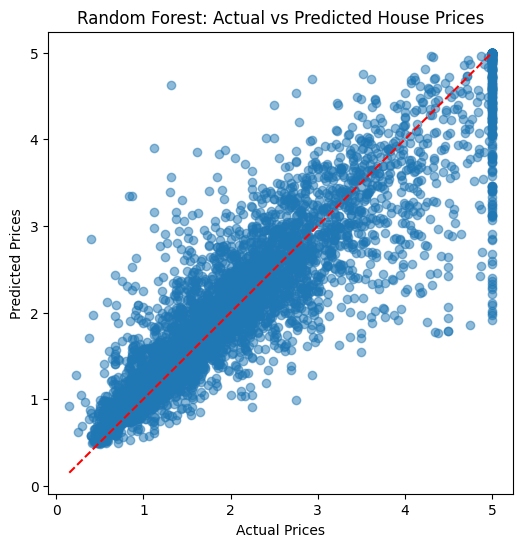

In [48]:
# Visual comparison between predicted vs actual prices
plt.figure(figsize=(6,6))
plt.scatter(val_y, cal_preds, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest: Actual vs Predicted House Prices")
plt.plot([val_y.min(), val_y.max()], [val_y.min(), val_y.max()], 'r--')
plt.show()


### Visual Insight
The closer the points are to the red dashed line, the better the model’s predictions.  
We can see the Random Forest model captures the trend well, with most predictions closely following the true prices.


# Final Model Training, Saving, and Feature Importance

In [49]:
final_model = RandomForestRegressor()
final_model.fit(X, y)

#Saving the model
joblib.dump(final_model, 'california_house_price_model.pkl')
print("✅ Final Random Forest model trained and saved as 'california_house_price_model.pkl'")

✅ Final Random Forest model trained and saved as 'california_house_price_model.pkl'


## Feature importance

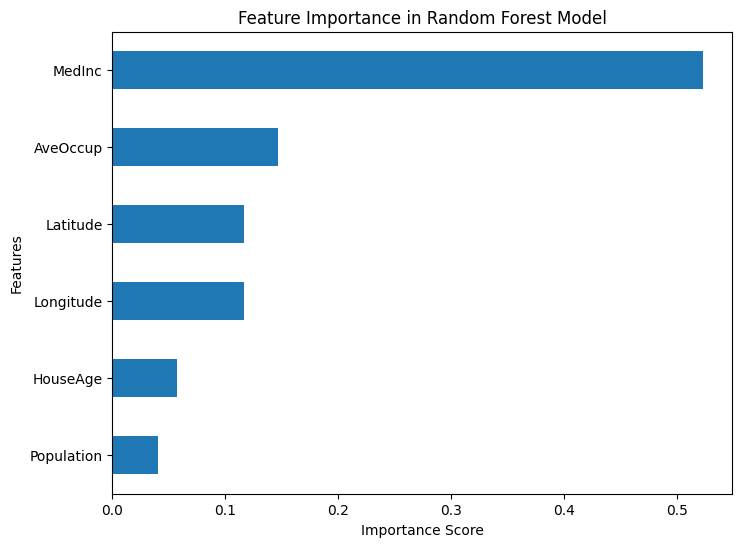

,0
MedInc,0.522470
AveOccup,0.146880
Latitude,0.116484
Longitude,0.116197
HouseAge,0.057313
Population,0.040656


In [50]:
# Feature importance visualization
feature_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Display numerical values
feature_importances.sort_values(ascending=False)


### Feature Importance Analysis

The chart shows how much each feature contributed to predicting house prices.

**Insights:**
- 🏦 **Median Income** is by far the most important predictor of house prices.
- 📍 **Latitude** and **Longitude** follow, showing the strong geographic influence.
- Other demographic variables like **Population** and **HouseAge** contribute less but still add useful context.


## 🏁 Conclusion

In this project, I:

1. Explored the California Housing dataset  
2. Compared **Decision Tree** and **Random Forest** regressors  
3. Found Random Forest achieved a lower MAE (~0.326), showing better predictive power  
4. Trained a final model on the full dataset and visualized feature importance  

**Next Steps:**
- Perform hyperparameter tuning using `GridSearchCV` for further improvement  
- Try feature engineering (e.g., combine location features or income-per-person)  
- Deploy the model using **Streamlit** or **Flask**

---

📌 *Project by [Naresh Tallapaka]*  
    #MachineLearning #DataScience #RandomForest #Regression #PortfolioProject
